<a href="https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from matplotlib import pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO
import os

### Defnining a custom RL environment

In [16]:
def a2p(action):
    return (action/4)
ver = "2.1f"

In [ ]:
class EVCharging(gym.Env):
    f"""
    ver {ver}: 
        - positive asymptotic reward for reaching 100% soc
    """

    # Define constants for clearer code
    ETA = float(0.9) #charging efficiency
    P_MAX = float(6.6) #maximum charging power of car
    DELTA_T = float(1) #1 hour
    B_MAX = float(40) #in kWh, maximum battery capacity
    rng = np.random.default_rng(seed=42) #random number generator for price vector
    PRICE_VEC = rng.random(24,)*10 #random price vector for 24 hours multiplied by 10 (range 0-100)
    PERIODS = 24 #24 hours
    
    
    def __init__(self):
        super(EVCharging, self).__init__()
        # action space is only discrete charging power (0 or max)
        self.action_space = spaces.Discrete(5) 

        # alternatively action space can be set as follows:
        # self.action_space = spaces.Box(0,1, shape=(1,), dtype=np.float32) 
        
        # The observation contains 3 states: soc, time, price
        # this can be described both by Discrete and Box space
        """observation space: time, electricity price, """
        self.observation_space = spaces.Box(low= 0, high= 1, shape=(3,), dtype=np.float32)
        # soc, time, price
        self.final_soc = 0

    def reset(self, seed=None, options=None):
        """
        Important: the observation must be a numpy array
        :return: (np.array)
        """
        # super().reset(seed=seed, options=options)
        # Initialize the agent at the right of the grid
        self.soc = 20 #20% soc
        self.soc_norm = self.soc/100 #normalized soc
        self.time = 0 #initial time
        self.time_norm = self.time/self.PERIODS #normalized time
        self.price = self.PRICE_VEC[0] #initial price
        self.price_norm = self.price/max(self.PRICE_VEC) #normalized price
        self.power = 0 #initial power

        
        #create observation
        obs = [self.soc_norm, self.time_norm, self.price_norm]
        obs = np.array(obs, dtype=np.float32)
        # here we convert to float32 to make it more general (in case we want to use continuous actions)
        info = {}
        info['batt_soc'] = self.soc
        info['time'] = self.time
        info['price'] = self.price
        
        return obs, info  #return array of observations 

    def step(self, action):
        
        #define possible transitions here.
        action = a2p(action)
        self.power = action*self.P_MAX #convert chosen action to power
        prev_price = self.price_norm #store previous price for reward calculation

        #transition to next state
        self.time += 1#adds to the time step counter
        self.time_norm = self.time/self.PERIODS

        self.price = self.PRICE_VEC[self.time] if self.time <24 else self.PRICE_VEC[0]
        self.price_norm = self.price/max(self.PRICE_VEC) #updates price for next state

        self.soc += self.power*self.ETA*self.DELTA_T/self.B_MAX*100 #previous soc + charged portion normalized by battery capacity
        self.soc_norm = self.soc/100 #updates soc for next state

        #check for termination
        truncated = bool(self.time >= 24)  # we limit the number of steps to 24 per episode
        terminated = truncated #setting time as the only termination condition
        self.done = True if terminated or truncated else False

        #cost penalty
        w1 = 1
        r_cost = -w1*action*self.DELTA_T*prev_price #penalty based on cost after taking an action at previous state

        #soc expectation positive reward, sparse
        w2 = 2
        inv = 1/(1-self.soc_norm)
        r_diff = +w2*(min(inv,10)) if truncated else 0 #penalty based on the expected soc after taking an action
        

        #constraint violation dense reward
        w3 = 5
        r_const = -w3 if bool(self.soc > 100) else 0 #if battery soc reaches more than 100% penalize
        

        #total reward
        reward = float(r_cost+r_diff+r_const)

        #create observation
        obs = [self.soc_norm, self.time_norm, self.price_norm] #compile to an list of observations, normalized to 0-1
        obs = np.array(obs, dtype=np.float32) #convert to array
        
        # pass information as dictionary
        info = {}

        info['batt_soc'] = self.soc
        info['time'] = self.time
        info['price'] = self.price
        info['r_cost_t'] = r_cost
        info['r_diff_t'] = r_diff
        info['r_const'] = r_const

        return (obs, reward, terminated, truncated, info)

    def close(self):
        pass

### Environment Validation

In [18]:
env = EVCharging()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

# Create the vectorized environment
env = make_vec_env(lambda: EVCharging(), n_envs=4)

### Training the agent

In [19]:
#training
n_timesteps = 1000_000 #1 mil
n_runs = 5 #10 trial runs

#instatiate path
modeldir = f"PPO_model_{ver}"
logdir = f"PPO_log_{ver}"

if not os.path.exists(modeldir):
    os.makedirs(modeldir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

import os

# Force Stable Baselines3 to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Your existing code
# ...

#create model
for i in range(n_runs):
    print(f"training run trial, {i+1}")
    logname = f"Training_{i+1}"
    model = PPO("MlpPolicy", env=env, verbose=0, tensorboard_log=logdir, seed=i*2)
    model.learn(total_timesteps=n_timesteps,progress_bar=True, tb_log_name=logname) # Train for a fixed number of timesteps

    #save model
    model.save(f"{modeldir}/{logname}")

### Testing the agent

In [20]:
## Testing the trained agent
model = PPO.load(f"PPO_model_{ver}\Training_2.zip") #load the RL model from the last training run
# create a vectorized environment of EVCharging
vec_env = make_vec_env(EVCharging)
# create a single environment of EVCharging
env = EVCharging()

n_steps = 24
total_reward = 0

action_RL = []
soc_RL = [env.reset()[1]['batt_soc']] #initial soc
time_RL = [env.reset()[1]['time']] #initial time
price_RL = [env.reset()[1]['price']] #initial price
reward_RL = []
total_reward_RL = []

obs = vec_env.reset()
for step in range(n_steps+1):
    action, _ = model.predict(obs) #1st step is based on reset()
    action_RL.append(action[0]/4)
    obs, reward, done, info = vec_env.step(action)
    soc_RL.append(info[0]['batt_soc'])
    time_RL.append(info[0]['time'])
    price_RL.append(info[0]['price'])

    # print(f"step {step} - action: {action[0]}, soc: {info[0]['batt_soc']}, time: {info[0]['time']}, price: {info[0]['price']}, reward: {reward[0]}")

    total_reward += reward[0]
    reward_RL.append(reward[0])
    total_reward_RL.append(total_reward)
    # print(obs[0], reward[0], done[0])

    if done[0]== True:
        break
action_RL.append(0)
#elementwise multiplication of action and price

print(f"total reward - RL = {total_reward}")
obj = sum(np.multiply(np.array(action_RL)*6.6, np.array(price_RL)))
obj = round(obj,2)
print(f"obj - exact = {obj}")

# print(len(soc_RL),len(price_RL),len(time_RL),len(reward_RL),len(total_reward_RL))
# print(f"time = {len(time_RL)}, soc = {len(soc_RL)}, price = {len(price_RL)}, reward = {len(reward_RL)}, total_reward = {len(total_reward_RL)}")

## Testing the exact solution  

#load decision variable
decision_var_norm = np.load("decision_var_norm.npy") #in forms of 0-1

#add 0 to the end of the decision variable
decision_var_norm = np.append(decision_var_norm, 0)
decision_var = decision_var_norm*4 #converted to 0 to 4

soc_exact = [env.reset()[1]['batt_soc']] #initial soc
total_reward = 0
reward_exact = []
total_reward_exact = []


obs = env.reset()
for step in range(n_steps):
    action = decision_var[step] #either 0 or 1
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    # print(obs, reward)
    soc_exact.append(info['batt_soc'])
    reward_exact.append(reward)
    total_reward_exact.append(total_reward)
soc_exact.pop()
print(f"total reward - Exact = {total_reward}")


obj = sum(np.multiply(np.array(decision_var_norm)*6.6, np.array(price_RL)))
#limit to 2 decimal places
obj = round(obj,2)
print(f"obj - exact = {obj}")

#print final soc
print(f"final soc - RL = {round(soc_RL[-1]/100,2)}")



total reward - RL = 19.155733212828636
obj - exact = 54.36
total reward - Exact = 18.963279267399802
obj - exact = 66.76
final soc - RL = 0.91


C:\Users\bpriambodo\AppData\Local\Temp\ipykernel_7648\1597241039.py:88: RuntimeWarning: divide by zero encountered in scalar divide
  inv = 1/(1-self.soc_norm)


### Results visualization

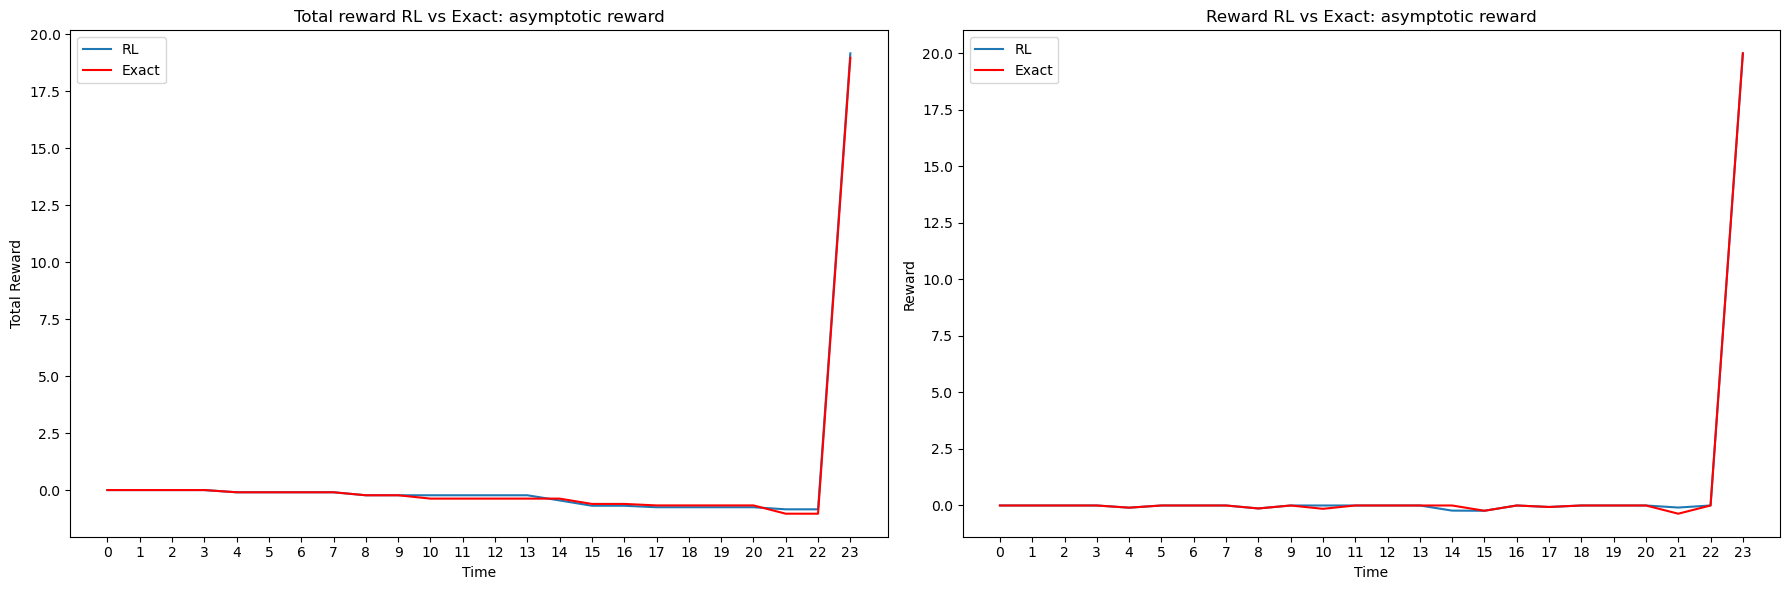

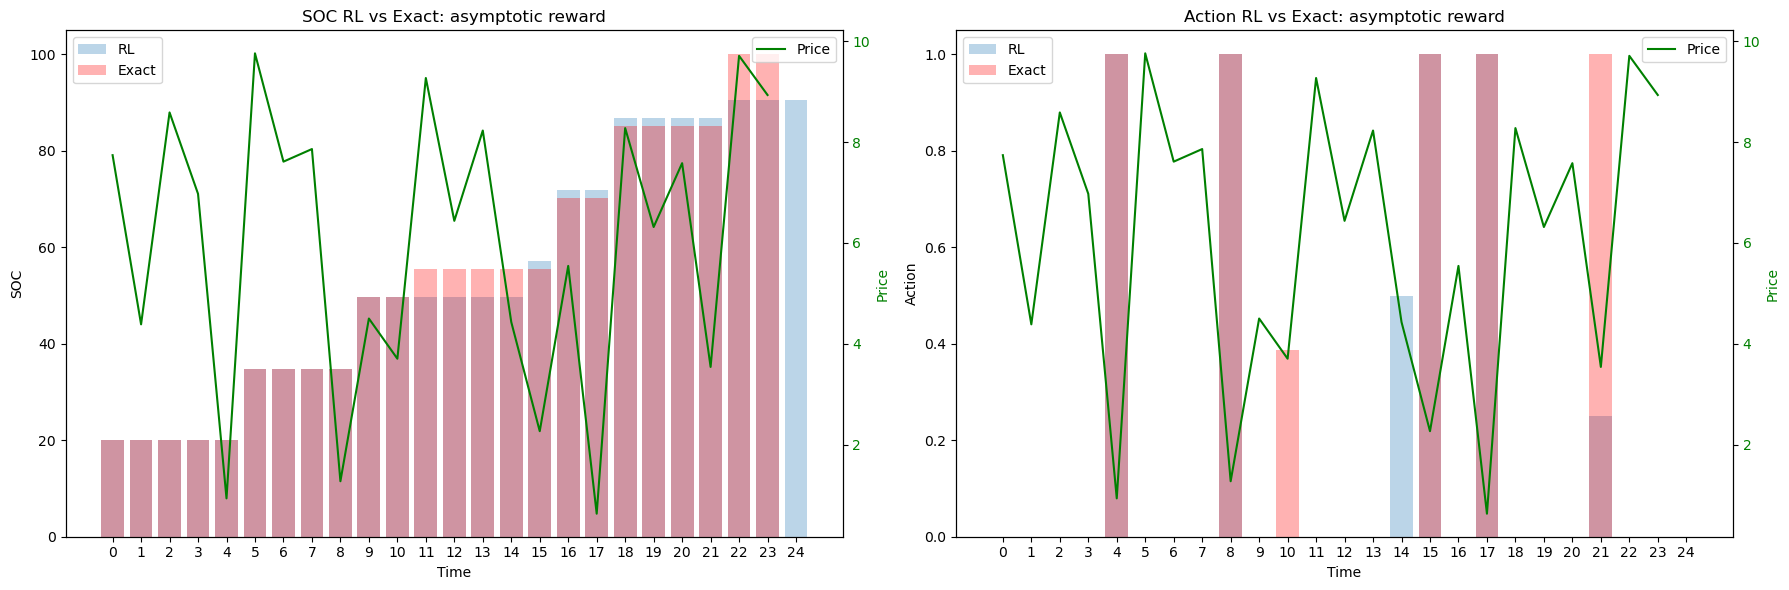

In [21]:
#plot total reward and reward side by side
title = "RL vs Exact: asymptotic reward"
figsize = (18, 6)

plt.figure(1, figsize=figsize)
plt.subplot(1,2,1)
plt.plot(total_reward_RL, label="RL")
plt.plot(total_reward_exact, label="Exact", color="red")
plt.xlabel("Time")
plt.ylabel("Total Reward")
plt.legend()
plt.title(f"Total reward {title}")
#create x tick labels
plt.xticks(np.arange(0, 24, 1))

#scale y axis from 0 to -1200

#plot reward_rl vs reward_exact
plt.subplot(1,2,2)
plt.plot(reward_RL, label="RL")
plt.plot(reward_exact, label="Exact", color="red")
plt.xlabel("Time")
plt.ylabel("Reward")
plt.legend()
plt.title(f"Reward {title}")
#create x tick labels
plt.xticks(np.arange(0, 24, 1))
plt.tight_layout()


#expand horizontal space
# plt.subplots_adjust(left=0.1, right=2, top=0.9, bottom=0.1)
plt.savefig(f"Images/rewardplot_{ver}.png")

##plot soc_rl vs soc_exact
plt.figure(2, figsize=figsize)
plt.subplot(1,2,1)
#plot soc_rl vs soc_exact
plt.bar(np.arange(0, len(soc_RL), 1), soc_RL, label="RL")
plt.bar(np.arange(0, 24, 1), soc_exact, label="Exact", color="red")

#set opacity
plt.setp(plt.gca().patches, alpha=0.3)

plt.xlabel("Time")
plt.ylabel("SOC")
plt.title(f"SOC {title}")
plt.legend(loc="upper left")
#create x tick labels
plt.xticks(np.arange(0, len(soc_RL), 1))

#plot price in the same figure but on the right y-axis
plt.twinx()
plt.plot(env.PRICE_VEC, label="Price", color='g')
plt.ylabel("Price", color='g')
#create x tick labels
plt.xticks(np.arange(0, len(soc_RL), 1))

plt.yticks(color='g')
plt.ylabel("Price", color='g')

#display legend on top right
plt.legend(loc="upper right")

## plot action_rl vs action_exact
plt.subplot(1,2,2)

#plot soc_rl vs soc_exact
plt.bar(np.arange(0, len(soc_RL), 1), np.array(action_RL), label="RL")
plt.bar(np.arange(0, len(decision_var_norm), 1), decision_var_norm, label="Exact", color="red")

#set opacity
plt.setp(plt.gca().patches, alpha=0.3)

plt.xlabel("Time")
plt.ylabel("Action")
plt.title(f"Action {title}")
plt.legend(loc="upper left")
#create x tick labels
plt.xticks(np.arange(0, len(soc_RL), 1))

#plot price in the same figure but on the right y-axis
plt.twinx()
plt.plot(env.PRICE_VEC, label="Price", color='g')

plt.ylabel("Price", color='g')
plt.yticks(color='g')


#display legend on top right
plt.legend(loc="upper right")
plt.tight_layout()

#expand horizontal space
# plt.subplots_adjust(left=0.1, right=2, top=0.9, bottom=0.1)
plt.savefig(f"Images/actionplot_{ver}.png")